In [1]:
import os
import shutil
import h5py
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import coregister, invert_ebb
from lameg.simulate import run_current_density_simulation
from lameg.laminar import model_comparison
from lameg.util import get_surface_names, load_meg_sensor_data
from lameg.viz import show_surface
import spm_standalone

In [3]:
nas = [-12.4, 86.4, -35.4]
lpa = [-49.4, 5.0, -41.7]
rpa = [51.8, 13.6, -41.7]

data_file = '/home/bonaiuto/laminar_baby/data/derivatives/P001_T1/Pspm_p001_t1_run01_epo.mat'

spm = spm_standalone.initialize()

In [4]:
mri_fname='/home/bonaiuto/laminar_baby/data/derivatives/217/6m/T1.nii'
multilayer_mesh_fname='/home/bonaiuto/laminar_baby/data/derivatives/217/6m/multilayer.11.ds.link_vector.fixed.gii'

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Get name of each mesh that makes up the layers of the multilayer mesh - these will be used for the source 
# reconstruction
layer_fnames = get_surface_names(
    n_layers, 
    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m', 
    'link_vector.fixed'
)

In [5]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/baby'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

In [6]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    fid_labels=['Nasion','LPA','RPA'],
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
24-Jul-2024 08:44:19 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 08:44:20 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           08:44:20 - 24/07/2024
multilayer.11.ds.link_vector.fixed
creating layout from cfg.grad
creating layout for neuromag306 system

SPM: spm_eeg_inv_forward                           08:45:12 -

24-Jul-2024 08:49:54 - Done    'Source inversion, iterative'
24-Jul-2024 08:49:54 - Done



In [7]:
data_fname=os.path.join(tmp_dir, 'SPMgainmatrix_Pspm_p001_t1_run01_epo_1.mat')
with h5py.File(data_fname, 'r') as file:
    G=file['G'][()]
    
n_layers=11
n_verts=G.shape[0]
verts_per_surf=int(n_verts/n_layers)

pial_G=G[:verts_per_surf,:]
white_G=G[(n_layers-1)*verts_per_surf:,]

rms=np.sqrt(np.sum((pial_G-white_G)**2,-1))

sim_vertex=np.argmax(rms)
print(sim_vertex)

29008


In [46]:
verts_per_surf

36262

Text(0, 0.5, 'Amplitude (nAm)')

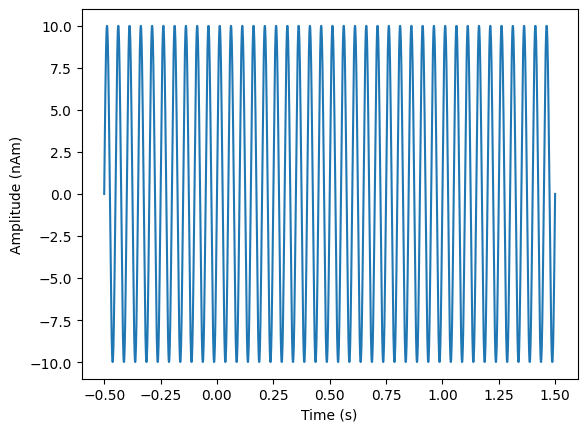

In [8]:
# Frequency of simulated sinusoid (Hz)
freq = 20
# Strength of simulated activity (nAm)
dipole_moment = 10
# Sampling rate (must match the data file)
s_rate = 2000

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time = np.linspace(-.5,1.5,s_rate+1)
sim_signal = np.sin(time*freq*2*np.pi).reshape(1,-1)

plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

In [9]:
pial_ds_mesh_fname = '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii'
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.gii'
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

Output()

IdleTimeout has been reached.
Parallel pool using the 'local' profile is shutting down.
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_pial_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 526.76 pAm/mm2, peak momemnt density 1280.64 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 526.76, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1280.64, sd 0.00 pAm/mm2
Saving /scra

(-225.0, 225.0)

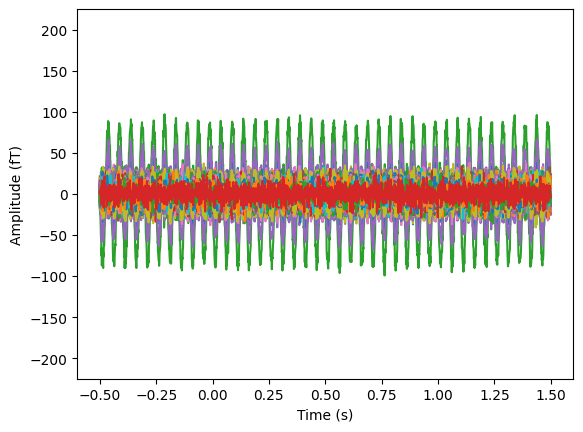

In [27]:
# Simulate at a vertex on the pial surface
pial_vertex = sim_vertex
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -15

# Generate simulated data
pial_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
)   

# Load simulated sensor data and plot
pial_sim_sensor_data, time, ch_names = load_meg_sensor_data(pial_sim_fname)
_ = plt.plot(time, np.mean(pial_sim_sensor_data,axis=-1).T)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT)')
plt.ylim([-225, 225])

In [28]:
# Run model comparison between the first layer (pial) and the last layer (white matter)
[F,_] = model_comparison(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    pial_sim_fname, 
    spm_instance=spm,
    coregister_kwargs={
        'fid_labels': ['Nasion','LPA','RPA']
    },
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': n_temp_modes    
    }
)

# The difference in free energy is an approximation of the Bayes factor between the two models
# This value should be positive (more model evidence for the pial layer model)
F[0]-F[1]

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 16:22:31 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:22:31 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           16:22:36 - 24/07/2024
pial.ds.link_vector.fixed
creating layout from cfg.grad
creating layout for neuromag306 system

SPM: spm_eeg_inv_forward                           16:22:50 - 24/07/2024
Completed                       

creating layout from cfg.grad
creating layout for neuromag306 system

SPM: spm_eeg_inv_forward                           16:23:56 - 24/07/2024
Completed                               :          16:23:56 - 24/07/2024
computing surface normals
24-Jul-2024 16:23:57 - Done    'Head model specification'
24-Jul-2024 16:23:57 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:23:57 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 trai

1165.2579903411388

In [29]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = (n_layers-1)*verts_per_surf+sim_vertex
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 
# Run model comparison between the first layer (pial) and the last layer (white matter)
[F,_] = model_comparison(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    white_sim_fname, 
    spm_instance=spm,
    coregister_kwargs={
        'fid_labels': ['Nasion','LPA','RPA']
    },
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': n_temp_modes,    
    }
)
    
# The difference in free energy is an approximation of the Bayes factor between the two models
# This value should be negative (more model evidence for the white matter layer model)
F[0]-F[1]

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_white_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 527.48 pAm/mm2, peak momemnt density 1547.08 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 527.48, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1547.08, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_white_Pspm_p001_t1_run01_epo/prior683788.mat
Setting white noise to give sensor level SNR of -15B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  



------------------------------------------------------------------------
24-Jul-2024 16:26:55 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:26:55 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           16:26:55 - 24/07/2024
white.ds.link_vector.fixed
creating layout from cfg.grad
creating layout for neuromag306 system

SPM: spm_eeg_inv_forward                           16:27:10 - 24/07/2024
Completed                               :          16:27:10 - 24/07/2024
computing surface normals
24-Jul-2024 16:27:11 - Done    'Head model specification'
24-Jul-2024 16:27:11 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not 

-1208.7956041721336

(-225.0, 225.0)

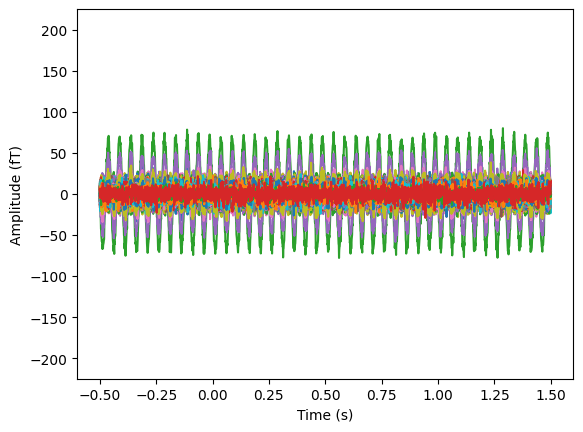

In [30]:
# Load simulated sensor data and plot
white_sim_sensor_data, time, ch_names = load_meg_sensor_data(white_sim_fname)
_ = plt.plot(time, np.mean(white_sim_sensor_data,axis=-1).T)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT)')
plt.ylim([-225, 225])

(-225.0, 225.0)

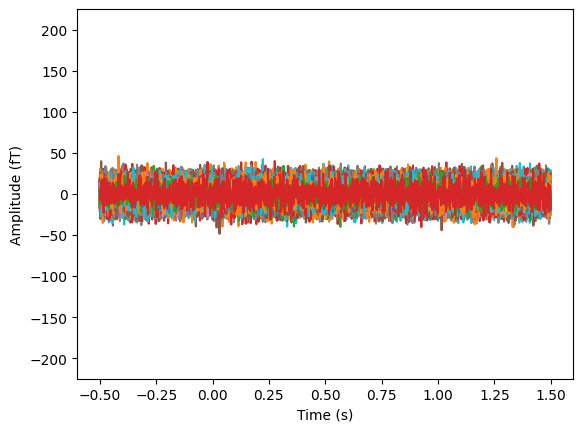

In [31]:
sensor_diff = pial_sim_sensor_data - white_sim_sensor_data
_ = plt.plot(time, np.mean(sensor_diff,axis=-1).T)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT)')
plt.ylim([-225, 225])

In [32]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run model comparison across
# all layers
all_layerF = []

for l in range(n_layers):
    print(f'Simulating in layer {l}')
    l_vertex = l*verts_per_surf+sim_vertex
    prefix = f'sim_{sim_vertex}_{l}_'

    l_sim_fname = run_current_density_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        dipole_moment, 
        sim_patch_size, 
        SNR,
        spm_instance=spm
    ) 

    [layerF,_] = model_comparison(
        nas, 
        lpa, 
        rpa, 
        mri_fname, 
        layer_fnames, 
        l_sim_fname, 
        viz=False,
        spm_instance=spm,
        coregister_kwargs={
            'fid_labels': ['Nasion','LPA','RPA']
        },
        invert_kwargs={
            'patch_size': patch_size, 
            'n_temp_modes': n_temp_modes        
        }
    )
    all_layerF.append(layerF)
all_layerF = np.array(all_layerF)

Simulating in layer 0
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_0_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 526.76 pAm/mm2, peak momemnt density 1280.64 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 526.76, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1280.64, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_0_Pspm_p001_t1_run01_epo/prior683788.mat
Setting white noise to give sensor level SNR of -15B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) U

Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 9.82 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.366289e+04 [+4.12]
  ReML Iteration 2                      :        ...1.087804e+04 [+4.25]
  ReML Iteration 3                      :        ...6.283638e+03 [+4.38]
  ReML Iteration 4                      :        ...1.6


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 16:31:49 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:31:49 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:32:59 - 24/07/2024
Completed                               :          16:32:59 - 24/07/2024
24-Jul-2024 16:32:59 - Done    'Head model specification'
24-Jul-2024 16:32:59 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:33:00 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.78 (9.80)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 16:34:02 - Done    'Source inversion, iterative'
24-Jul-2024 16:34:02 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 16:34:03 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:34:03 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:34:17 - 24

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.342068e+04 [+4.12]
  ReML Iteration 2                      :        ...1.066528e+04 [+4.25]
  ReML Iteration 3                      :        ...6.133281e+03 [+4.38]
  ReML Iteration 4                      :        ...1.601863e+03 [+4.50]
  ReML Iteration 5                      :        ...7.488491e+01 [+4.62]
  ReML Iteration 6                      :        ...1.304595e-01 [+4.75]
  ReML Iteration 7                      :        ...1.766518e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.342068e+04 [+4.12]
  ReML Iteration 2                      :        ...1.066528e+04 [+4.25]
  ReML Iteration 3                      :        ...6.133281e+03 [+4.38]
  ReML Iteration 4                      :        ...1.601863e+03 [+4.50]
  ReML Iteration 5                      :        ...7.488491e+01 [+4.62]
  ReML Iteration 6                      :        ...1.304595e-01 



------------------------------------------------------------------------
24-Jul-2024 16:36:22 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:36:22 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 9.82 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov



------------------------------------------------------------------------
24-Jul-2024 16:39:09 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:39:09 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:39:23 - 24/07/2024
Completed                               :          16:39:24 - 24/07/2024
24-Jul-2024 16:39:24 - Done    'Head model specification'
24-Jul-2024 16:39:24 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.84 (9.82)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 16:40:26 - Done    'Source inversion, iterative'
24-Jul-2024 16:40:26 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 16:40:27 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:40:27 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:40:42 - 24

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.342249e+04 [+4.12]
  ReML Iteration 2                      :        ...1.069111e+04 [+4.25]
  ReML Iteration 3                      :        ...6.175614e+03 [+4.38]
  ReML Iteration 4                      :        ...1.624749e+03 [+4.50]
  ReML Iteration 5                      :        ...7.668395e+01 [+4.62]
  ReML Iteration 6                      :        ...1.394804e-01 [+4.75]
  ReML Iteration 7                      :        ...3.044176e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.342249e+04 [+4.12]
  ReML Iteration 2                      :        ...1.069111e+04 [+4.25]
  ReML Iteration 3                      :        ...6.175614e+03 [+4.38]
  ReML Iteration 4                      :        ...1.624749e+03 [+4.50]
  ReML Iteration 5                      :        ...7.668395e+01 [+4.62]
  ReML Iteration 6                      :        ...1.394804e-01 



------------------------------------------------------------------------
24-Jul-2024 16:42:47 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:42:47 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 9.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:43:57 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
24-Jul-2024 16:45:00 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:45:00 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:45:14 - 24/07/2024
Completed                               :          16:45:15 - 24/07/2024
24-Jul-2024 16:45:15 - Done    'Head model specification'
24-Jul-2024 16:45:15 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 9.82 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.360558e+04 [+4.12]
  ReML Iteration 2                      :        ...1.086329e+04 [+4.25]
  ReML Iteration 3                      :        ...6.319163e+03 [+4.38]
  ReML Iteration 4                      :        ...1.688515e+03 [+4.50]
  ReML Iteration 5                      :        ...8.230747e+01 [+4.62]
  ReML Iteration 6             


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 16:49:11 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:49:11 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:50:20 - 24/07/2024
Completed                               :          16:50:20 - 24/07/2024
24-Jul-2024 16:50:21 - Done    'Head model specification'
24-Jul-2024 16:50:21 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:50:21 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.80 (9.80)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 16:51:23 - Done    'Source inversion, iterative'
24-Jul-2024 16:51:23 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 16:51:24 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:51:24 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:51:38 - 24

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.339408e+04 [+4.12]
  ReML Iteration 2                      :        ...1.067740e+04 [+4.25]
  ReML Iteration 3                      :        ...6.186774e+03 [+4.38]
  ReML Iteration 4                      :        ...1.647918e+03 [+4.50]
  ReML Iteration 5                      :        ...8.053974e+01 [+4.62]
  ReML Iteration 6                      :        ...1.496484e-01 [+4.75]
  ReML Iteration 7                      :        ...1.418454e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.339408e+04 [+4.12]
  ReML Iteration 2                      :        ...1.067740e+04 [+4.25]
  ReML Iteration 3                      :        ...6.186774e+03 [+4.38]
  ReML Iteration 4                      :        ...1.647918e+03 [+4.50]
  ReML Iteration 5                      :        ...8.053974e+01 [+4.62]
  ReML Iteration 6                      :        ...1.496484e-01 



------------------------------------------------------------------------
24-Jul-2024 16:53:43 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:53:43 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 9.82 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov



------------------------------------------------------------------------
24-Jul-2024 16:56:26 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:56:26 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:56:44 - 24/07/2024
Completed                               :          16:56:44 - 24/07/2024
24-Jul-2024 16:56:44 - Done    'Head model specification'
24-Jul-2024 16:56:44 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.84 (9.84)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 16:57:46 - Done    'Source inversion, iterative'
24-Jul-2024 16:57:46 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 16:57:47 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 16:57:47 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:58:01 - 24

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.371090e+04 [+4.12]
  ReML Iteration 2                      :        ...1.092943e+04 [+4.25]
  ReML Iteration 3                      :        ...6.323446e+03 [+4.38]
  ReML Iteration 4                      :        ...1.662724e+03 [+4.50]
  ReML Iteration 5                      :        ...7.815060e+01 [+4.62]
  ReML Iteration 6                      :        ...1.438840e-01 [+4.75]
  ReML Iteration 7                      :        ...6.330222e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.371090e+04 [+4.12]
  ReML Iteration 2                      :        ...1.092943e+04 [+4.25]
  ReML Iteration 3                      :        ...6.323446e+03 [+4.38]
  ReML Iteration 4                      :        ...1.662724e+03 [+4.50]
  ReML Iteration 5                      :        ...7.815060e+01 [+4.62]
  ReML Iteration 6                      :        ...1.438840e-01 



------------------------------------------------------------------------
24-Jul-2024 17:00:06 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:00:06 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 9.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:01:16 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
24-Jul-2024 17:02:19 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:02:19 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:02:33 - 24/07/2024
Completed                               :          17:02:33 - 24/07/2024
24-Jul-2024 17:02:33 - Done    'Head model specification'
24-Jul-2024 17:02:33 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.78 (9.83)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 17:03:35 - Done    'Source inversion, iterative'
24-Jul-2024 17:03:35 - Done

Simulating in layer 4
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_4_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 524.22 pAm/mm2, peak momemnt density 1448.43 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment densi

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 17:06:28 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:06:28 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:07:39 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
24-Jul-2024 17:08:41 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:08:41 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:08:55 - 24/07/2024
Completed                               :          17:08:56 - 24/07/2024
24-Jul-2024 17:08:56 - Done    'Head model specification'
24-Jul-2024 17:08:56 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.81 (9.89)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 17:09:58 - Done    'Source inversion, iterative'
24-Jul-2024 17:09:58 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 17:09:59 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:09:59 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:10:13 - 24

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.340157e+04 [+4.12]
  ReML Iteration 2                      :        ...1.066317e+04 [+4.25]
  ReML Iteration 3                      :        ...6.160010e+03 [+4.38]
  ReML Iteration 4                      :        ...1.630280e+03 [+4.50]
  ReML Iteration 5                      :        ...7.874017e+01 [+4.62]
  ReML Iteration 6                      :        ...1.418596e-01 [+4.75]
  ReML Iteration 7                      :        ...1.095046e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.340157e+04 [+4.12]
  ReML Iteration 2                      :        ...1.066317e+04 [+4.25]
  ReML Iteration 3                      :        ...6.160010e+03 [+4.38]
  ReML Iteration 4                      :        ...1.630280e+03 [+4.50]
  ReML Iteration 5                      :        ...7.874017e+01 [+4.62]
  ReML Iteration 6                      :        ...1.418596e-01 



------------------------------------------------------------------------
24-Jul-2024 17:12:17 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:12:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 9.91 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov



------------------------------------------------------------------------
24-Jul-2024 17:15:04 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:15:04 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:15:18 - 24/07/2024
Completed                               :          17:15:18 - 24/07/2024
24-Jul-2024 17:15:18 - Done    'Head model specification'
24-Jul-2024 17:15:18 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.82 (9.90)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 17:16:20 - Done    'Source inversion, iterative'
24-Jul-2024 17:16:20 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 17:16:21 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:16:21 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:16:35 - 24

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.366460e+04 [+4.12]
  ReML Iteration 2                      :        ...1.090354e+04 [+4.25]
  ReML Iteration 3                      :        ...6.322165e+03 [+4.38]
  ReML Iteration 4                      :        ...1.669392e+03 [+4.50]
  ReML Iteration 5                      :        ...7.902595e+01 [+4.62]
  ReML Iteration 6                      :        ...1.479957e-01 [+4.75]
  ReML Iteration 7                      :        ...6.723975e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.366460e+04 [+4.12]
  ReML Iteration 2                      :        ...1.090354e+04 [+4.25]
  ReML Iteration 3                      :        ...6.322165e+03 [+4.38]
  ReML Iteration 4                      :        ...1.669392e+03 [+4.50]
  ReML Iteration 5                      :        ...7.902595e+01 [+4.62]
  ReML Iteration 6                      :        ...1.479957e-01 



------------------------------------------------------------------------
24-Jul-2024 17:18:40 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:18:40 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 9.92 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:19:51 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
24-Jul-2024 17:20:54 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:20:54 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:21:08 - 24/07/2024
Completed                               :          17:21:08 - 24/07/2024
24-Jul-2024 17:21:08 - Done    'Head model specification'
24-Jul-2024 17:21:08 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 9.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.359042e+04 [+4.12]
  ReML Iteration 2                      :        ...1.088212e+04 [+4.25]
  ReML Iteration 3                      :        ...6.366491e+03 [+4.38]
  ReML Iteration 4                      :        ...1.721836e+03 [+4.50]
  ReML Iteration 5                      :        ...8.606124e+01 [+4.62]
  ReML Iteration 6             


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 17:25:03 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:25:03 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:26:13 - 24/07/2024
Completed                               :          17:26:13 - 24/07/2024
24-Jul-2024 17:26:13 - Done    'Head model specification'
24-Jul-2024 17:26:13 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:26:14 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.85 (9.94)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 17:27:16 - Done    'Source inversion, iterative'
24-Jul-2024 17:27:16 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 17:27:17 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:27:17 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:27:31 - 24

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.368166e+04 [+4.12]
  ReML Iteration 2                      :        ...1.095738e+04 [+4.25]
  ReML Iteration 3                      :        ...6.409142e+03 [+4.38]
  ReML Iteration 4                      :        ...1.731239e+03 [+4.50]
  ReML Iteration 5                      :        ...8.640504e+01 [+4.62]
  ReML Iteration 6                      :        ...1.766233e-01 [+4.75]
  ReML Iteration 7                      :        ...5.708522e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.368166e+04 [+4.12]
  ReML Iteration 2                      :        ...1.095738e+04 [+4.25]
  ReML Iteration 3                      :        ...6.409142e+03 [+4.38]
  ReML Iteration 4                      :        ...1.731239e+03 [+4.50]
  ReML Iteration 5                      :        ...8.640504e+01 [+4.62]
  ReML Iteration 6                      :        ...1.766233e-01 



------------------------------------------------------------------------
24-Jul-2024 17:29:37 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:29:37 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 9.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov



------------------------------------------------------------------------
24-Jul-2024 17:32:20 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:32:21 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:32:38 - 24/07/2024
Completed                               :          17:32:39 - 24/07/2024
24-Jul-2024 17:32:39 - Done    'Head model specification'
24-Jul-2024 17:32:39 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.84 (9.93)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 17:33:41 - Done    'Source inversion, iterative'
24-Jul-2024 17:33:41 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 17:33:42 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:33:42 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:33:56 - 24

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.367534e+04 [+4.12]
  ReML Iteration 2                      :        ...1.092663e+04 [+4.25]
  ReML Iteration 3                      :        ...6.354538e+03 [+4.38]
  ReML Iteration 4                      :        ...1.689612e+03 [+4.50]
  ReML Iteration 5                      :        ...8.117761e+01 [+4.62]
  ReML Iteration 6                      :        ...1.561633e-01 [+4.75]
  ReML Iteration 7                      :        ...7.089035e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.367534e+04 [+4.12]
  ReML Iteration 2                      :        ...1.092663e+04 [+4.25]
  ReML Iteration 3                      :        ...6.354538e+03 [+4.38]
  ReML Iteration 4                      :        ...1.689612e+03 [+4.50]
  ReML Iteration 5                      :        ...8.117761e+01 [+4.62]
  ReML Iteration 6                      :        ...1.561633e-01 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 17:36:02 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:36:02 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:37:13 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
24-Jul-2024 17:38:16 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:38:16 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:38:30 - 24/07/2024
Completed                               :          17:38:30 - 24/07/2024
24-Jul-2024 17:38:30 - Done    'Head model specification'
24-Jul-2024 17:38:30 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.77 (9.92)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 17:39:33 - Done    'Source inversion, iterative'
24-Jul-2024 17:39:33 - Done

Simulating in layer 8
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_8_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 532.56 pAm/mm2, peak momemnt density 1592.88 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment densi



------------------------------------------------------------------------
24-Jul-2024 17:42:26 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:42:27 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 10.02 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:43:37 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
24-Jul-2024 17:44:40 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:44:40 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:44:54 - 24/07/2024
Completed                               :          17:44:54 - 24/07/2024
24-Jul-2024 17:44:54 - Done    'Head model specification'
24-Jul-2024 17:44:54 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.84 (10.00)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 17:45:57 - Done    'Source inversion, iterative'
24-Jul-2024 17:45:57 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 17:45:57 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:45:57 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:46:11 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.375917e+04 [+4.12]
  ReML Iteration 2                      :        ...1.103311e+04 [+4.25]
  ReML Iteration 3                      :        ...6.469477e+03 [+4.38]
  ReML Iteration 4                      :        ...1.755035e+03 [+4.50]
  ReML Iteration 5                      :        ...8.824321e+01 [+4.62]
  ReML Iteration 6                      :        ...1.836913e-01 [+4.75]
  ReML Iteration 7                      :        ...7.588782e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.375917e+04 [+4.12]
  ReML Iteration 2                      :        ...1.103311e+04 [+4.25]
  ReML Iteration 3                      :        ...6.469477e+03 [+4.38]
  ReML Iteration 4                      :        ...1.755035e+03 [+4.50]
  ReML Iteration 5                      :        ...8.824321e+01 [+4.62]
  ReML Iteration 6                      :        ...1.836913e-01 



------------------------------------------------------------------------
24-Jul-2024 17:48:16 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:48:16 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 10.02 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
24-Jul-2024 17:51:04 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:51:04 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:51:18 - 24/07/2024
Completed                               :          17:51:18 - 24/07/2024
24-Jul-2024 17:51:18 - Done    'Head model specification'
24-Jul-2024 17:51:18 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.81 (10.08)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 17:52:21 - Done    'Source inversion, iterative'
24-Jul-2024 17:52:21 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 17:52:22 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:52:22 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:52:36 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.354627e+04 [+4.12]
  ReML Iteration 2                      :        ...1.084360e+04 [+4.25]
  ReML Iteration 3                      :        ...6.340009e+03 [+4.38]
  ReML Iteration 4                      :        ...1.713771e+03 [+4.50]
  ReML Iteration 5                      :        ...8.555079e+01 [+4.62]
  ReML Iteration 6                      :        ...1.745809e-01 [+4.75]
  ReML Iteration 7                      :        ...4.928669e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.354627e+04 [+4.12]
  ReML Iteration 2                      :        ...1.084360e+04 [+4.25]
  ReML Iteration 3                      :        ...6.340009e+03 [+4.38]
  ReML Iteration 4                      :        ...1.713771e+03 [+4.50]
  ReML Iteration 5                      :        ...8.555079e+01 [+4.62]
  ReML Iteration 6                      :        ...1.745809e-01 



------------------------------------------------------------------------
24-Jul-2024 17:54:41 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:54:41 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 10.10 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:55:51 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
24-Jul-2024 17:56:54 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 17:56:54 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:57:08 - 24/07/2024
Completed                               :          17:57:09 - 24/07/2024
24-Jul-2024 17:57:09 - Done    'Head model specification'
24-Jul-2024 17:57:09 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 10.19 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.343066e+04 [+4.12]
  ReML Iteration 2                      :        ...1.078334e+04 [+4.25]
  ReML Iteration 3                      :        ...6.355653e+03 [+4.38]
  ReML Iteration 4                      :        ...1.760644e+03 [+4.50]
  ReML Iteration 5                      :        ...9.346243e+01 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 18:01:06 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 18:01:06 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:02:16 - 24/07/2024
Completed                               :          18:02:16 - 24/07/2024
24-Jul-2024 18:02:16 - Done    'Head model specification'
24-Jul-2024 18:02:16 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      18:02:16 - 24/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.82 (10.17)
model evidences relative to maximum:

ans =

     0

24-Jul-2024 18:03:18 - Done    'Source inversion, iterative'
24-Jul-2024 18:03:18 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
24-Jul-2024 18:03:19 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 18:03:19 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:03:33 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.370380e+04 [+4.12]
  ReML Iteration 2                      :        ...1.102603e+04 [+4.25]
  ReML Iteration 3                      :        ...6.523559e+03 [+4.38]
  ReML Iteration 4                      :        ...1.810608e+03 [+4.50]
  ReML Iteration 5                      :        ...9.574493e+01 [+4.62]
  ReML Iteration 6                      :        ...2.173901e-01 [+4.75]
  ReML Iteration 7                      :        ...6.683877e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.370380e+04 [+4.12]
  ReML Iteration 2                      :        ...1.102603e+04 [+4.25]
  ReML Iteration 3                      :        ...6.523559e+03 [+4.38]
  ReML Iteration 4                      :        ...1.810608e+03 [+4.50]
  ReML Iteration 5                      :        ...9.574493e+01 [+4.62]
  ReML Iteration 6                      :        ...2.173901e-01 



------------------------------------------------------------------------
24-Jul-2024 18:05:38 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 18:05:38 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 10.19 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pr

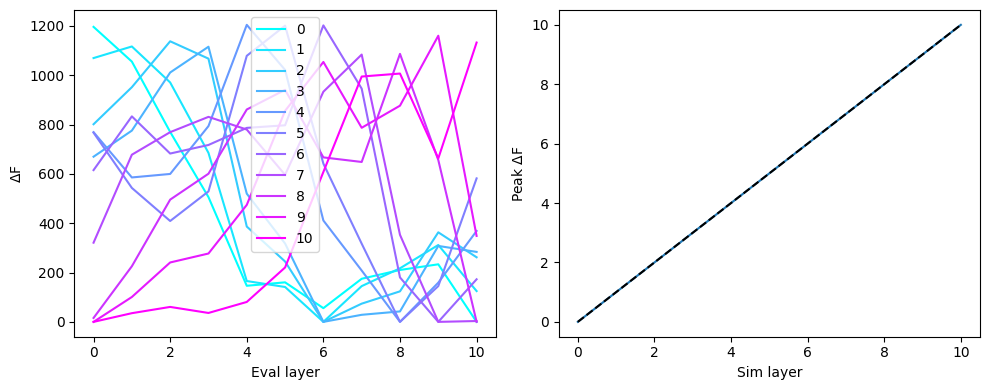

In [33]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the free energy of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(n_layers):
    layerF = all_layerF[l,:]
    plt.plot(layerF-np.min(layerF), label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel(r'$\Delta$F')

# For each simulation, find which layer model had the greatest free energy
plt.subplot(1,2,2)
peaks = []
for l in range(n_layers):
    layerF = all_layerF[l,:]
    pk = np.argmax(layerF)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel(r'Peak $\Delta$F')
plt.tight_layout()

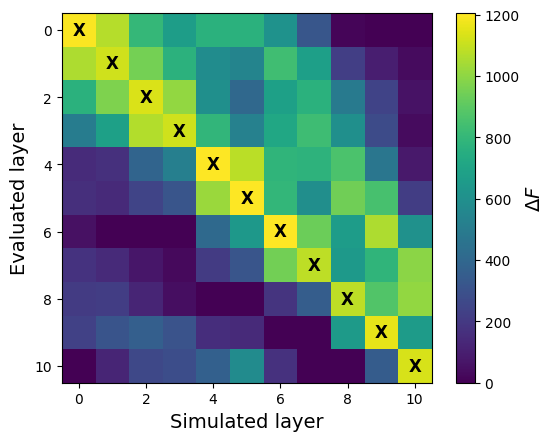

In [44]:
# Normalization step
norm_layerF = np.zeros(all_layerF.shape)
for l in range(n_layers):
    norm_layerF[l,:] = all_layerF[l,:] - np.min(all_layerF[l,:])

# Transpose for visualization
im=plt.imshow(norm_layerF.T)

# Find the indices of the max value in each column
max_indices = np.argmax(norm_layerF, axis=1)

# Plot an 'X' at the center of the square for each column's maximum
for idx, max_idx in enumerate(max_indices):
    plt.text(idx, max_idx, 'X', fontsize=12, ha='center', va='center', color='black', weight='bold')

plt.xlabel('Simulated layer', fontsize=14)
plt.ylabel('Evaluated layer', fontsize=14)
cb=plt.colorbar(im)
cb.set_label(r'$\Delta F$', fontsize=14)

In [45]:
def diagonal_off_diagonal_ratio(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input matrix must be square.")
    
    # Extract diagonal elements
    diagonal_elements = np.diag(matrix)
    
    # Compute the 2-norm of diagonal elements
    diagonal_norm = np.linalg.norm(diagonal_elements)
    
    # Compute the Frobenius norm of the entire matrix
    total_norm = np.linalg.norm(matrix, ord='fro')
    
    # Calculate the norm of off-diagonal elements
    off_diagonal_norm = np.sqrt(total_norm**2 - diagonal_norm**2)
    
    # Calculate the ratio
    ratio = diagonal_norm / off_diagonal_norm if off_diagonal_norm != 0 else np.inf
    
    return ratio

def fraction_not_skew_symmetric(A):
    # Compute the skew-symmetric part of A
    skew_symmetric_part = (A - A.T) / 2
    
    # Compute the Frobenius norm of the original matrix
    frobenius_norm_A = np.linalg.norm(A, 'fro')
    
    # Compute the Frobenius norm of the skew-symmetric part
    frobenius_norm_skew = np.linalg.norm(skew_symmetric_part, 'fro')
    
    # Calculate the fraction of the total energy that is not skew-symmetric
    fraction_not_skew = 1 - (frobenius_norm_skew / (np.sqrt(2) * frobenius_norm_A))**2
    
    return fraction_not_skew

def correlation_coefficient(matrix):
    d = matrix.shape[0]
    j = np.ones(d)
    r = np.arange(1, d + 1)

    # Compute the sum of all entries in the matrix
    n = np.sum(matrix)

    # Compute ?x, ?y, ?x^2, ?y^2, and ?xy using matrix A and vectors r and j
    sum_x = np.dot(r, np.dot(matrix, j))
    sum_y = np.dot(j, np.dot(matrix, r))
    sum_x2 = np.dot(r**2, np.dot(matrix, j))
    sum_y2 = np.dot(j, np.dot(matrix, r**2))
    sum_xy = np.dot(r, np.dot(matrix, r))

    # Compute the numerator and denominator for the correlation coefficient
    numerator = n * sum_xy - sum_x * sum_y
    denominator = np.sqrt(n * sum_x2 - sum_x**2) * np.sqrt(n * sum_y2 - sum_y**2)

    # Calculate the correlation coefficient
    correlation = numerator / denominator

    return correlation


# Example usage
ratio = diagonal_off_diagonal_ratio(norm_layerF)
print("diagonal_off_diagonal_ratio:", ratio)
fraction = fraction_not_skew_symmetric(norm_layerF)
print("fraction_not_skew_symmetric:", fraction)
corr = correlation_coefficient(norm_layerF)
print("correlation_coefficient:", corr)

diagonal_off_diagonal_ratio: 0.6388952155192101
fraction_not_skew_symmetric: 0.9358774507276877
correlation_coefficient: 0.4793437049257135
